In [1]:
!pip install torch_optimizer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 4.1 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from transformers import AutoModel, AutoTokenizer
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.cuda.amp import autocast, GradScaler
from torch_optimizer import AdamP
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.corpus import stopwords
import string
import re
import pandas as pd
import matplotlib.pyplot as plt
from transformers import DistilBertTokenizer
from sklearn.metrics import precision_score, recall_score, f1_score

In [3]:

train_df = pd.read_csv('/kaggle/input/cyber-guard-hackathon/train.csv')
val_df = pd.read_csv('/kaggle/input/cyber-guard-hackathon/test.csv')
train_df

,category,sub_category,crimeaditionalinfo
0,Online and Social Media Related Crime,Cyber Bullying Stalking Sexting,I had continue received random calls and abusi...
1,Online Financial Fraud,Fraud CallVishing,The above fraudster is continuously messaging ...
2,Online Gambling Betting,Online Gambling Betting,He is acting like a police and demanding for m...
3,Online and Social Media Related Crime,Online Job Fraud,In apna Job I have applied for job interview f...
4,Online Financial Fraud,Fraud CallVishing,I received a call from lady stating that she w...
...,...,...,...
93681,Online Financial Fraud,Internet Banking Related Fraud,Identity theft Smishing SMS Fraud CreditDeb...
93682,Online Financial Fraud,EWallet Related Fraud,RECEIVED CALL FROM NUMBER ASKING ABOUT phone ...
93683,Online Financial Fraud,UPI Related Frauds,Cyber Stalking Blackmailing PhoneSMSVOIP C...
93684,Online and Social Media Related Crime,Online Matrimonial Fraud,Call karke bola ki aapka lotary laga ha aru AC...


In [4]:
train_df.isnull().sum()

category                 0
sub_category          6591
crimeaditionalinfo      21
dtype: int64

In [5]:
val_df.isnull().sum()

category                 0
sub_category          2236
crimeaditionalinfo       7
dtype: int64

here we will fill the empty sub_category with nan values and treat it like a class to classify and drop the empty text columns

In [6]:
train_df["sub_category"].fillna("NaN",inplace=True)
train_df.dropna(inplace=True)
train_df

/tmp/ipykernel_22/958489091.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df["sub_category"].fillna("NaN",inplace=True)


,category,sub_category,crimeaditionalinfo
0,Online and Social Media Related Crime,Cyber Bullying Stalking Sexting,I had continue received random calls and abusi...
1,Online Financial Fraud,Fraud CallVishing,The above fraudster is continuously messaging ...
2,Online Gambling Betting,Online Gambling Betting,He is acting like a police and demanding for m...
3,Online and Social Media Related Crime,Online Job Fraud,In apna Job I have applied for job interview f...
4,Online Financial Fraud,Fraud CallVishing,I received a call from lady stating that she w...
...,...,...,...
93681,Online Financial Fraud,Internet Banking Related Fraud,Identity theft Smishing SMS Fraud CreditDeb...
93682,Online Financial Fraud,EWallet Related Fraud,RECEIVED CALL FROM NUMBER ASKING ABOUT phone ...
93683,Online Financial Fraud,UPI Related Frauds,Cyber Stalking Blackmailing PhoneSMSVOIP C...
93684,Online and Social Media Related Crime,Online Matrimonial Fraud,Call karke bola ki aapka lotary laga ha aru AC...


In [7]:
val_df["sub_category"].fillna("NaN",inplace=True)
val_df.dropna(inplace=True)
val_df

/tmp/ipykernel_22/2176640310.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  val_df["sub_category"].fillna("NaN",inplace=True)


,category,sub_category,crimeaditionalinfo
0,RapeGang Rape RGRSexually Abusive Content,NaN,Sir namaskar mein Ranjit Kumar PatraPaise neh...
1,Online Financial Fraud,DebitCredit Card FraudSim Swap Fraud,KOTAK MAHINDRA BANK FRAUD\r\nFRAUD AMOUNT
2,Cyber Attack/ Dependent Crimes,SQL Injection,The issue actually started when I got this ema...
3,Online Financial Fraud,Fraud CallVishing,I am amit kumar from karwi chitrakoot I am tot...
4,Any Other Cyber Crime,Other,I have ordered saree and blouse from rinki s...
...,...,...,...
31224,Online and Social Media Related Crime,Online Matrimonial Fraud,A lady named Rashmi probably a fake name had c...
31225,Online Financial Fraud,Internet Banking Related Fraud,I am Mr Chokhe Ram Two pers mobile number wer...
31226,Any Other Cyber Crime,Other,Mai Bibekbraj maine pahle ki complain kar chuk...
31227,Online Financial Fraud,Internet Banking Related Fraud,received URL link for updating KYC from mobile...


In [8]:
num_category = len(train_df["category"].unique())
categories = train_df["category"].unique()
print(f"There are {num_category} category and they are {categories} in train data")

There are 15 category and they are ['Online and Social Media Related Crime' 'Online Financial Fraud'
 'Online Gambling  Betting' 'RapeGang Rape RGRSexually Abusive Content'
 'Any Other Cyber Crime' 'Cyber Attack/ Dependent Crimes'
 'Cryptocurrency Crime' 'Sexually Explicit Act'
 'Sexually Obscene material'
 'Hacking  Damage to computercomputer system etc' 'Cyber Terrorism'
 'Child Pornography CPChild Sexual Abuse Material CSAM'
 'Online Cyber Trafficking' 'Ransomware' 'Report Unlawful Content'] in train data


In [9]:
num_category = len(train_df["sub_category"].unique())
sub_categories = train_df["sub_category"].unique()
print(f"There are {num_category} sub_category and they are {sub_categories} in train data")

There are 36 sub_category and they are ['Cyber Bullying  Stalking  Sexting' 'Fraud CallVishing'
 'Online Gambling  Betting' 'Online Job Fraud' 'UPI Related Frauds'
 'Internet Banking Related Fraud' 'NaN' 'Other'
 'Profile Hacking Identity Theft' 'DebitCredit Card FraudSim Swap Fraud'
 'EWallet Related Fraud' 'Data Breach/Theft' 'Cheating by Impersonation'
 'Denial of Service (DoS)/Distributed Denial of Service (DDOS) attacks'
 'FakeImpersonating Profile' 'Cryptocurrency Fraud' 'Malware Attack'
 'Business Email CompromiseEmail Takeover' 'Email Hacking'
 'Hacking/Defacement' 'Unauthorised AccessData Breach' 'SQL Injection'
 'Provocative Speech for unlawful acts' 'Ransomware Attack'
 'Cyber Terrorism' 'Tampering with computer source documents'
 'DematDepository Fraud' 'Online Trafficking' 'Online Matrimonial Fraud'
 'Website DefacementHacking' 'Damage to computer computer systems etc'
 'Impersonating Email' 'EMail Phishing' 'Ransomware' 'Intimidating Email'
 'Against Interest of sovereign

In [10]:
num_category = len(val_df["category"].unique())
categories = val_df["sub_category"].unique()
print(f"There are {num_category} category and they are {categories} in test data")

There are 15 category and they are ['NaN' 'DebitCredit Card FraudSim Swap Fraud' 'SQL Injection'
 'Fraud CallVishing' 'Other' 'Internet Banking Related Fraud'
 'Unauthorised AccessData Breach' 'UPI Related Frauds'
 'Damage to computer computer systems etc' 'Cheating by Impersonation'
 'Malware Attack' 'EWallet Related Fraud' 'EMail Phishing'
 'Profile Hacking Identity Theft' 'Data Breach/Theft'
 'FakeImpersonating Profile' 'Email Hacking' 'Online Job Fraud'
 'Cyber Bullying  Stalking  Sexting' 'Hacking/Defacement'
 'Cryptocurrency Fraud' 'Online Matrimonial Fraud'
 'Tampering with computer source documents'
 'Denial of Service (DoS)/Distributed Denial of Service (DDOS) attacks'
 'DematDepository Fraud' 'Provocative Speech for unlawful acts'
 'Online Gambling  Betting' 'Ransomware Attack'
 'Business Email CompromiseEmail Takeover' 'Online Trafficking'
 'Cyber Terrorism' 'Impersonating Email' 'Website DefacementHacking'
 'Ransomware' 'Computer Generated CSAM/CSEM' 'Intimidating Email'
 '

In [11]:
num_category = len(val_df["sub_category"].unique())
sub_categories = val_df["sub_category"].unique()
print(f"There are {num_category} sub_category and they are {sub_categories} in test data")

There are 38 sub_category and they are ['NaN' 'DebitCredit Card FraudSim Swap Fraud' 'SQL Injection'
 'Fraud CallVishing' 'Other' 'Internet Banking Related Fraud'
 'Unauthorised AccessData Breach' 'UPI Related Frauds'
 'Damage to computer computer systems etc' 'Cheating by Impersonation'
 'Malware Attack' 'EWallet Related Fraud' 'EMail Phishing'
 'Profile Hacking Identity Theft' 'Data Breach/Theft'
 'FakeImpersonating Profile' 'Email Hacking' 'Online Job Fraud'
 'Cyber Bullying  Stalking  Sexting' 'Hacking/Defacement'
 'Cryptocurrency Fraud' 'Online Matrimonial Fraud'
 'Tampering with computer source documents'
 'Denial of Service (DoS)/Distributed Denial of Service (DDOS) attacks'
 'DematDepository Fraud' 'Provocative Speech for unlawful acts'
 'Online Gambling  Betting' 'Ransomware Attack'
 'Business Email CompromiseEmail Takeover' 'Online Trafficking'
 'Cyber Terrorism' 'Impersonating Email' 'Website DefacementHacking'
 'Ransomware' 'Computer Generated CSAM/CSEM' 'Intimidating Email

so there are some unseen labels in the test set we would first see what the unseen labels are

In [12]:
def check_unseen_labels(train_labels, test_labels):
    train_set = set(train_labels)
    test_set = set(test_labels)
    unseen_labels = test_set - train_set
    return unseen_labels

# Get unseen categories
unseen_categories = check_unseen_labels(train_df['category'], val_df['category'])
unseen_sub_categories = check_unseen_labels(train_df['sub_category'], val_df['sub_category'])

# Output unseen labels
print("Unseen Categories:", unseen_categories)
print(len(unseen_categories))
print("Unseen Sub-categories:", unseen_sub_categories)
print(len(unseen_sub_categories))

Unseen Categories: {'Crime Against Women & Children'}
1
Unseen Sub-categories: {'Computer Generated CSAM/CSEM', 'Sexual Harassment', 'Cyber Blackmailing & Threatening'}
3


In [13]:
# viewing the unseen category
val_df[val_df["category"]=="Crime Against Women & Children"]

,category,sub_category,crimeaditionalinfo
2762,Crime Against Women & Children,Computer Generated CSAM/CSEM,My friend mentioned something like this happen...
9517,Crime Against Women & Children,Computer Generated CSAM/CSEM,The issue actually started when I got this ema...
14779,Crime Against Women & Children,Cyber Blackmailing & Threatening,My friend mentioned something like this happen...
19725,Crime Against Women & Children,Sexual Harassment,I never imagined something like this could hap...


so removing the unseen labels would only remove 4 rows of data here

In [14]:
val_df = val_df[val_df["category"]!="Crime Against Women & Children"]
val_df

,category,sub_category,crimeaditionalinfo
0,RapeGang Rape RGRSexually Abusive Content,NaN,Sir namaskar mein Ranjit Kumar PatraPaise neh...
1,Online Financial Fraud,DebitCredit Card FraudSim Swap Fraud,KOTAK MAHINDRA BANK FRAUD\r\nFRAUD AMOUNT
2,Cyber Attack/ Dependent Crimes,SQL Injection,The issue actually started when I got this ema...
3,Online Financial Fraud,Fraud CallVishing,I am amit kumar from karwi chitrakoot I am tot...
4,Any Other Cyber Crime,Other,I have ordered saree and blouse from rinki s...
...,...,...,...
31224,Online and Social Media Related Crime,Online Matrimonial Fraud,A lady named Rashmi probably a fake name had c...
31225,Online Financial Fraud,Internet Banking Related Fraud,I am Mr Chokhe Ram Two pers mobile number wer...
31226,Any Other Cyber Crime,Other,Mai Bibekbraj maine pahle ki complain kar chuk...
31227,Online Financial Fraud,Internet Banking Related Fraud,received URL link for updating KYC from mobile...


In [15]:
# rechecking if there are still some unseen rows left
unseen_sub_categories = check_unseen_labels(train_df['sub_category'], val_df['sub_category'])
unseen_sub_categories

set()

In [16]:
category_encoder = LabelEncoder()
sub_category_encoder = LabelEncoder()


# Fit and transform each column
train_df['category'] = category_encoder.fit_transform(train_df['category'])
train_df['sub_category'] = sub_category_encoder.fit_transform(train_df['sub_category'])

train_df

,category,sub_category,crimeaditionalinfo
0,9,4,I had continue received random calls and abusi...
1,7,15,The above fraudster is continuously messaging ...
2,8,22,He is acting like a police and demanding for m...
3,9,23,In apna Job I have applied for job interview f...
4,7,15,I received a call from lady stating that she w...
...,...,...,...
93681,7,18,Identity theft Smishing SMS Fraud CreditDeb...
93682,7,12,RECEIVED CALL FROM NUMBER ASKING ABOUT phone ...
93683,7,33,Cyber Stalking Blackmailing PhoneSMSVOIP C...
93684,9,24,Call karke bola ki aapka lotary laga ha aru AC...


In [17]:
val_df['category'] = category_encoder.transform(val_df['category'])
val_df['sub_category'] = sub_category_encoder.transform(val_df['sub_category'])

val_df

/tmp/ipykernel_22/1939397347.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['category'] = category_encoder.transform(val_df['category'])
/tmp/ipykernel_22/1939397347.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['sub_category'] = sub_category_encoder.transform(val_df['sub_category'])


,category,sub_category,crimeaditionalinfo
0,11,21,Sir namaskar mein Ranjit Kumar PatraPaise neh...
1,7,8,KOTAK MAHINDRA BANK FRAUD\r\nFRAUD AMOUNT
2,3,31,The issue actually started when I got this ema...
3,7,15,I am amit kumar from karwi chitrakoot I am tot...
4,0,26,I have ordered saree and blouse from rinki s...
...,...,...,...
31224,9,24,A lady named Rashmi probably a fake name had c...
31225,7,18,I am Mr Chokhe Ram Two pers mobile number wer...
31226,0,26,Mai Bibekbraj maine pahle ki complain kar chuk...
31227,7,18,received URL link for updating KYC from mobile...


In [18]:
import re
import string
import spacy
from nltk.corpus import stopwords
from tqdm.auto import tqdm
from tqdm.notebook import tqdm_notebook
import time

nlp = spacy.load('en_core_web_sm')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    """
    Clean text by:
    1. Converting to lowercase
    2. Removing newlines, tabs, and extra spaces
    3. Removing punctuation
    4. Removing numbers
    5. Removing stopwords
    
    Args:
        text (str): Input text to clean
        
    Returns:
        str: Cleaned text with named entities replaced
    """
    try:
        # Convert to lowercase
        text = text.lower()
        
        # Remove newlines, tabs, and extra spaces
        text = re.sub(r'\n|\r|\t', ' ', text)
        
        # Remove punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))
        
        # Remove numbers
        text = re.sub(r'\d+', '', text)
        
        # Remove extra spaces
        text = re.sub(r'\s+', ' ', text).strip()
        
        return text
    
    except Exception as e:
        print(f"Error processing text: {str(e)}")
        return text

train_df['cleaned_text'] = train_df['crimeaditionalinfo'].apply(clean_text)

In [19]:
train_df

,category,sub_category,crimeaditionalinfo,cleaned_text
0,9,4,I had continue received random calls and abusi...,i had continue received random calls and abusi...
1,7,15,The above fraudster is continuously messaging ...,the above fraudster is continuously messaging ...
2,8,22,He is acting like a police and demanding for m...,he is acting like a police and demanding for m...
3,9,23,In apna Job I have applied for job interview f...,in apna job i have applied for job interview f...
4,7,15,I received a call from lady stating that she w...,i received a call from lady stating that she w...
...,...,...,...,...
93681,7,18,Identity theft Smishing SMS Fraud CreditDeb...,identity theft smishing sms fraud creditdebit ...
93682,7,12,RECEIVED CALL FROM NUMBER ASKING ABOUT phone ...,received call from number asking about phone p...
93683,7,33,Cyber Stalking Blackmailing PhoneSMSVOIP C...,cyber stalking blackmailing phonesmsvoip calls...
93684,9,24,Call karke bola ki aapka lotary laga ha aru AC...,call karke bola ki aapka lotary laga ha aru ac...


In [20]:
val_df['cleaned_text'] = val_df['crimeaditionalinfo'].apply(clean_text)
val_df

/tmp/ipykernel_22/2912841513.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['cleaned_text'] = val_df['crimeaditionalinfo'].apply(clean_text)


,category,sub_category,crimeaditionalinfo,cleaned_text
0,11,21,Sir namaskar mein Ranjit Kumar PatraPaise neh...,sir namaskar mein ranjit kumar patrapaise nehi...
1,7,8,KOTAK MAHINDRA BANK FRAUD\r\nFRAUD AMOUNT,kotak mahindra bank fraud fraud amount
2,3,31,The issue actually started when I got this ema...,the issue actually started when i got this ema...
3,7,15,I am amit kumar from karwi chitrakoot I am tot...,i am amit kumar from karwi chitrakoot i am tot...
4,0,26,I have ordered saree and blouse from rinki s...,i have ordered saree and blouse from rinki sur...
...,...,...,...,...
31224,9,24,A lady named Rashmi probably a fake name had c...,a lady named rashmi probably a fake name had c...
31225,7,18,I am Mr Chokhe Ram Two pers mobile number wer...,i am mr chokhe ram two pers mobile number were...
31226,0,26,Mai Bibekbraj maine pahle ki complain kar chuk...,mai bibekbraj maine pahle ki complain kar chuk...
31227,7,18,received URL link for updating KYC from mobile...,received url link for updating kyc from mobile...


In [21]:
train_df = train_df.drop_duplicates(subset=['cleaned_text'])
train_df

,category,sub_category,crimeaditionalinfo,cleaned_text
0,9,4,I had continue received random calls and abusi...,i had continue received random calls and abusi...
1,7,15,The above fraudster is continuously messaging ...,the above fraudster is continuously messaging ...
2,8,22,He is acting like a police and demanding for m...,he is acting like a police and demanding for m...
3,9,23,In apna Job I have applied for job interview f...,in apna job i have applied for job interview f...
4,7,15,I received a call from lady stating that she w...,i received a call from lady stating that she w...
...,...,...,...,...
93681,7,18,Identity theft Smishing SMS Fraud CreditDeb...,identity theft smishing sms fraud creditdebit ...
93682,7,12,RECEIVED CALL FROM NUMBER ASKING ABOUT phone ...,received call from number asking about phone p...
93683,7,33,Cyber Stalking Blackmailing PhoneSMSVOIP C...,cyber stalking blackmailing phonesmsvoip calls...
93684,9,24,Call karke bola ki aapka lotary laga ha aru AC...,call karke bola ki aapka lotary laga ha aru ac...


In [22]:
val_df = val_df.drop_duplicates(subset=['cleaned_text'])
val_df

,category,sub_category,crimeaditionalinfo,cleaned_text
0,11,21,Sir namaskar mein Ranjit Kumar PatraPaise neh...,sir namaskar mein ranjit kumar patrapaise nehi...
1,7,8,KOTAK MAHINDRA BANK FRAUD\r\nFRAUD AMOUNT,kotak mahindra bank fraud fraud amount
2,3,31,The issue actually started when I got this ema...,the issue actually started when i got this ema...
3,7,15,I am amit kumar from karwi chitrakoot I am tot...,i am amit kumar from karwi chitrakoot i am tot...
4,0,26,I have ordered saree and blouse from rinki s...,i have ordered saree and blouse from rinki sur...
...,...,...,...,...
31224,9,24,A lady named Rashmi probably a fake name had c...,a lady named rashmi probably a fake name had c...
31225,7,18,I am Mr Chokhe Ram Two pers mobile number wer...,i am mr chokhe ram two pers mobile number were...
31226,0,26,Mai Bibekbraj maine pahle ki complain kar chuk...,mai bibekbraj maine pahle ki complain kar chuk...
31227,7,18,received URL link for updating KYC from mobile...,received url link for updating kyc from mobile...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Calculating token lengths:   0%|          | 0/79428 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (514 > 512). Running this sequence through the model will result in indexing errors


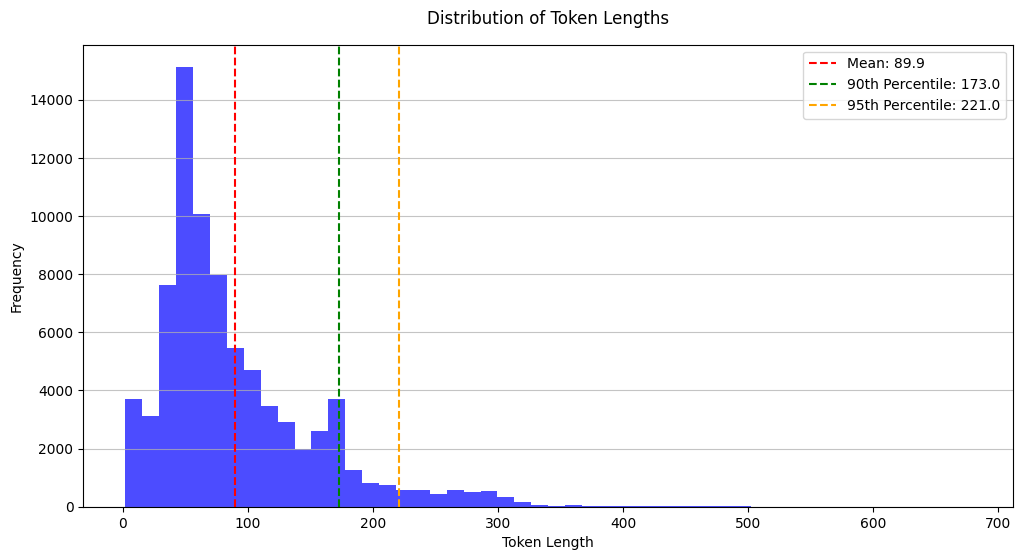


Detailed Token Length Statistics:
----------------------------------------
Mean Length: 89.88
90th Percentile: 173.00
95th Percentile: 221.00

Full Statistical Summary:
       Token Length
count  79428.000000
mean      89.877839
std       64.217103
min        2.000000
25%       47.000000
50%       70.000000
75%      117.000000
90%      173.000000
95%      221.000000
max      678.000000


In [23]:
texts = train_df['cleaned_text'].astype(str).tolist() 
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')


token_lengths = []
for text in tqdm(texts, desc="Calculating token lengths"):
    encoding = tokenizer(text, truncation=False, padding=False) 
    token_lengths.append(len(encoding['input_ids']))

length_df = pd.DataFrame(token_lengths, columns=['Token Length'])

# Calculate statistics
mean_length = length_df['Token Length'].mean()
percentile_90 = length_df['Token Length'].quantile(0.90)
percentile_95 = length_df['Token Length'].quantile(0.95)

# Create plot
plt.figure(figsize=(12, 6))
plt.hist(length_df['Token Length'], bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Token Lengths', fontsize=12, pad=15)
plt.xlabel('Token Length', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.grid(axis='y', alpha=0.75)

# Add vertical lines for statistics
plt.axvline(mean_length, color='red', linestyle='dashed', linewidth=1.5)
plt.axvline(percentile_90, color='green', linestyle='dashed', linewidth=1.5)
plt.axvline(percentile_95, color='orange', linestyle='dashed', linewidth=1.5)

# Add legend
plt.legend({
    f'Mean: {mean_length:.1f}': mean_length,
    f'90th Percentile: {percentile_90:.1f}': percentile_90,
    f'95th Percentile: {percentile_95:.1f}': percentile_95
}, loc='upper right')

plt.show()

# Print detailed statistics
print("\nDetailed Token Length Statistics:")
print("-" * 40)
print(f"Mean Length: {mean_length:.2f}")
print(f"90th Percentile: {percentile_90:.2f}")
print(f"95th Percentile: {percentile_95:.2f}")
print("\nFull Statistical Summary:")
print(length_df.describe([.25, .5, .75, .9, .95]))

In [24]:
MAX_LENGTH = 225
BATCH_SIZE = 32
LEARNING_RATE = 5e-5
NUM_EPOCHS = 5
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
PATIENCE = 5  
PATIENCE_LR = 3  

In [25]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

from torch.cuda.amp import GradScaler
from itertools import cycle

scaler = GradScaler()

def coral_loss(source, target):
    d = source.size(1)
    source_covar = (source - source.mean(0)).t() @ (source - source.mean(0)) / (source.size(0) - 1)
    target_covar = (target - target.mean(0)).t() @ (target - target.mean(0)) / (target.size(0) - 1)
    loss = torch.sum((source_covar - target_covar) ** 2) / (4 * d * d)
    return loss


def mmd_loss(source_features, target_features, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
    n_samples = int(source_features.size()[0]) + int(target_features.size()[0])
    total = torch.cat([source_features, target_features], dim=0)
    
    L2_distance = ((total.unsqueeze(0) - total.unsqueeze(1)) ** 2).sum(2)
    if fix_sigma:
        bandwidth = fix_sigma
    else:
        bandwidth = torch.sum(L2_distance.data) / (n_samples**2 - n_samples)
    bandwidth /= kernel_mul ** (kernel_num // 2)
    bandwidth_list = [bandwidth * (kernel_mul ** i) for i in range(kernel_num)]
    kernel_val = [torch.exp(-L2_distance / bandwidth_temp) for bandwidth_temp in bandwidth_list]
   
    kernels = sum(kernel_val)
    XX = kernels[:source_features.size()[0], :source_features.size()[0]]
    YY = kernels[source_features.size()[0]:, source_features.size()[0]:]
    XY = kernels[:source_features.size()[0], source_features.size()[0]:]
    YX = kernels[source_features.size()[0]:, :source_features.size()[0]]
    
    return torch.mean(XX + YY - XY - YX)


# Define the hierarchical classification model with MMD and CORAL loss
class CategoryModel(nn.Module):
    def __init__(self, num_categories, dropout_rate=0.3):
        super(CategoryModel, self).__init__()
        self.base_model = AutoModel.from_pretrained("distilbert-base-uncased")
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dense = nn.Linear(self.base_model.config.hidden_size, self.base_model.config.hidden_size // 2)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.activation = nn.GELU()
        self.category_classifier = nn.Linear(self.base_model.config.hidden_size // 2, num_categories)

    def forward(self, input_ids, attention_mask,return_features=False):
        outputs = self.base_model(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs[0][:, 0, :]  
        x = self.dropout1(pooled_output)
        x = self.dense(x)
        x = self.activation(x)
        x = self.dropout2(x)
        if return_features:
            return self.category_classifier(x), x 
        return self.category_classifier(x)

    
class SubCategoryModel(nn.Module):
    def __init__(self, num_sub_categories, dropout_rate=0.3):
        super(SubCategoryModel, self).__init__()
        self.base_model = AutoModel.from_pretrained("distilbert-base-uncased")
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dense = nn.Linear(self.base_model.config.hidden_size, self.base_model.config.hidden_size // 2)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.activation = nn.GELU()
        self.sub_category_classifier = nn.Linear(self.base_model.config.hidden_size // 2, num_sub_categories)

    def forward(self, input_ids, attention_mask,return_features=False):
        outputs = self.base_model(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs[0][:, 0, :]  
        x = self.dropout1(pooled_output)
        x = self.dense(x)
        x = self.activation(x)
        x = self.dropout2(x)
        if return_features:
            return self.sub_category_classifier(x), x 
        return self.sub_category_classifier(x)

   
    
def compute_accuracy(preds, labels):
    return (preds == labels).sum().item() / len(labels)


class TextDataset(Dataset):
    def __init__(self, texts, labels1, labels2):
        self.texts = texts
        self.labels1 = labels1  
        self.labels2 = labels2  
        self.encodings = tokenizer(texts, truncation=True, padding='max_length', max_length=MAX_LENGTH, return_tensors="pt")

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        item = {key: val[idx].to(DEVICE) for key, val in self.encodings.items()}
        item['labels1'] = torch.tensor(self.labels1[idx], device=DEVICE)
        item['labels2'] = torch.tensor(self.labels2[idx], device=DEVICE)
        return item

    
train_dataset = TextDataset(train_df['cleaned_text'].astype(str).tolist(), train_df['category'].tolist(), train_df['sub_category'].tolist())
val_dataset = TextDataset(val_df['cleaned_text'].astype(str).tolist(), val_df['category'].tolist(), val_df['sub_category'].tolist())

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,drop_last=True)


# Initialize separate models for category and sub_category
category_model = CategoryModel(num_categories=len(category_encoder.classes_)).to(DEVICE)
sub_category_model = SubCategoryModel(num_sub_categories=len(sub_category_encoder.classes_)).to(DEVICE)

optimizer_params = {
    'lr': LEARNING_RATE,
    'weight_decay': 0.01,  # L2 regularization
    'betas': (0.9, 0.999),
    'eps': 1e-8
}

optimizer_category = AdamP(category_model.parameters(), **optimizer_params)
optimizer_sub_category = AdamP(sub_category_model.parameters(), **optimizer_params)

scaler = GradScaler()
scheduler_category = ReduceLROnPlateau(optimizer_category, mode='min', patience=PATIENCE_LR, factor=0.5, verbose=True)
scheduler_sub_category = ReduceLROnPlateau(optimizer_sub_category, mode='min', patience=PATIENCE_LR, factor=0.5, verbose=True)


def compute_metrics(preds, labels):
    accuracy = (preds == labels).sum().item() / len(labels)
    precision = precision_score(labels.cpu(), preds.cpu(), average='macro', zero_division=0)
    recall = recall_score(labels.cpu(), preds.cpu(), average='macro', zero_division=0)
    f1 = f1_score(labels.cpu(), preds.cpu(), average='macro', zero_division=0)
    return accuracy, precision, recall, f1


import torch
import torch.nn as nn
from tqdm import tqdm

def top_k_accuracy(logits, labels, k=1):
    _, top_k_preds = torch.topk(logits, k=k, dim=1)
    correct = top_k_preds.eq(labels.view(-1, 1).expand_as(top_k_preds))
    return correct.sum().float() / labels.size(0)

def validate(category_model, sub_category_model, val_loader):
    category_model.eval()
    sub_category_model.eval()

    total_val_loss1, total_val_loss2 = 0, 0
    total_val_acc1, total_val_acc2 = 0, 0
    total_val_precision1, total_val_recall1, total_val_f1_1 = 0, 0, 0
    total_val_precision2, total_val_recall2, total_val_f1_2 = 0, 0, 0

    top_k_accs1 = {2: 0, 3: 0, 5: 0}
    top_k_accs2 = {2: 0, 3: 0, 5: 0}

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validating"):
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            labels1, labels2 = batch['labels1'].to(DEVICE), batch['labels2'].to(DEVICE)

            # Category prediction
            logits1 = category_model(input_ids=input_ids, attention_mask=attention_mask)
            loss1 = nn.CrossEntropyLoss()(logits1, labels1)
            category_preds = torch.argmax(torch.softmax(logits1, dim=1), dim=1)

            # Sub-category prediction
            logits2 = sub_category_model(input_ids=input_ids, attention_mask=attention_mask)
            loss2 = nn.CrossEntropyLoss()(logits2, labels2)
            sub_category_preds = torch.argmax(torch.softmax(logits2, dim=1), dim=1)

            # Calculate metrics for category
            acc1, precision1, recall1, f1_1 = compute_metrics(category_preds, labels1)
            total_val_acc1 += acc1
            total_val_precision1 += precision1
            total_val_recall1 += recall1
            total_val_f1_1 += f1_1

            # Calculate top-k accuracy for category
            for k in top_k_accs1.keys():
                top_k_accs1[k] += top_k_accuracy(logits1, labels1, k=k)

            # Calculate metrics for sub-category
            acc2, precision2, recall2, f1_2 = compute_metrics(sub_category_preds, labels2)
            total_val_acc2 += acc2
            total_val_precision2 += precision2
            total_val_recall2 += recall2
            total_val_f1_2 += f1_2

            # Calculate top-k accuracy for sub-category
            for k in top_k_accs2.keys():
                top_k_accs2[k] += top_k_accuracy(logits2, labels2, k=k)

            # Accumulate losses
            total_val_loss1 += loss1.item()
            total_val_loss2 += loss2.item()

    avg_val_loss1 = total_val_loss1 / len(val_loader)
    avg_val_loss2 = total_val_loss2 / len(val_loader)
    avg_val_acc1 = total_val_acc1 / len(val_loader)
    avg_val_acc2 = total_val_acc2 / len(val_loader)
    avg_val_precision1 = total_val_precision1 / len(val_loader)
    avg_val_recall1 = total_val_recall1 / len(val_loader)
    avg_val_f1_1 = total_val_f1_1 / len(val_loader)
    avg_val_precision2 = total_val_precision2 / len(val_loader)
    avg_val_recall2 = total_val_recall2 / len(val_loader)
    avg_val_f1_2 = total_val_f1_2 / len(val_loader)

    # Average top-k accuracies
    avg_top_k_accs1 = {k: top_k_accs1[k] / len(val_loader) for k in top_k_accs1}
    avg_top_k_accs2 = {k: top_k_accs2[k] / len(val_loader) for k in top_k_accs2}

    # Print results
    print(f"Category Validation Loss: {avg_val_loss1:.4f}")
    print(f"Sub-category Validation Loss: {avg_val_loss2:.4f}")
    print(f"Category Accuracy: {avg_val_acc1:.4f}, Precision: {avg_val_precision1:.4f}, Recall: {avg_val_recall1:.4f}, F1: {avg_val_f1_1:.4f}")
    print(f"Sub-category Accuracy: {avg_val_acc2:.4f}, Precision: {avg_val_precision2:.4f}, Recall: {avg_val_recall2:.4f}, F1: {avg_val_f1_2:.4f}")
    
    # Print top-k accuracies
    for k in avg_top_k_accs1:
        print(f"Top-{k} Category Accuracy: {avg_top_k_accs1[k]:.4f}")
    for k in avg_top_k_accs2:
        print(f"Top-{k} Sub-category Accuracy: {avg_top_k_accs2[k]:.4f}")


# Training loop for the hierarchical classification
def train(category_model, sub_category_model, train_loader, val_loader, epochs):
    category_model.train()
    sub_category_model.train()
    val_cycle = cycle(val_loader)
    print("started model training")
    for epoch in range(epochs):
        total_train_loss1 = 0.0
        total_train_loss2 = 0.0
        total_train_acc1, total_train_precision1, total_train_recall1, total_train_f1_1 = 0.0, 0.0, 0.0, 0.0
        total_train_acc2, total_train_precision2, total_train_recall2, total_train_f1_2 = 0.0, 0.0, 0.0, 0.0

        # Initialize tqdm for batch logging
        train_loader_iter = tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{epochs}")

        for batch in train_loader_iter:
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            labels1 = batch['labels1']
            labels2 = batch['labels2']

            # Validation batch for MMD/CORAL calculations
            val_batch = next(val_cycle)
            input_ids_val, attention_mask_val = val_batch['input_ids'].to(DEVICE), val_batch['attention_mask'].to(DEVICE)

            optimizer_category.zero_grad()
            optimizer_sub_category.zero_grad()

            # Forward pass for category classification
            with torch.amp.autocast('cuda'):
                logits1, features1 = category_model(input_ids=input_ids, attention_mask=attention_mask, return_features=True)
                loss1 = nn.CrossEntropyLoss()(logits1, labels1)
                _, val_features1 = category_model(input_ids=input_ids_val, attention_mask=attention_mask_val, return_features=True)
                mmd1 = mmd_loss(features1, val_features1)
                coral1 = coral_loss(features1, val_features1)

                total_loss1 = loss1 + 0.6 * mmd1 + 0.6 * coral1
                category_preds = torch.argmax(torch.softmax(logits1, dim=1), dim=1)

                scaler.scale(total_loss1).backward(retain_graph=True)
                scaler.step(optimizer_category)

                # Forward pass for sub-category classification
                logits2, features2 = sub_category_model(input_ids=input_ids, attention_mask=attention_mask, return_features=True)
                loss2 = nn.CrossEntropyLoss()(logits2, labels2)
                _, val_features2 = sub_category_model(input_ids=input_ids_val, attention_mask=attention_mask_val, return_features=True)
                mmd2 = mmd_loss(features2, val_features2)
                coral2 = coral_loss(features2, val_features2)

                total_loss2 = loss2 + 0.2 * mmd2 + 0.2 * coral2
                sub_category_preds = torch.argmax(torch.softmax(logits2, dim=1), dim=1)

                scaler.scale(total_loss2).backward()
                scaler.step(optimizer_sub_category)

            scaler.update()

            # Update total loss and accuracy for logging
            total_train_loss1 += total_loss1.item()
            total_train_loss2 += total_loss2.item()

            acc1, precision1, recall1, f1_1 = compute_metrics(category_preds, labels1)
            total_train_acc1 += acc1
            total_train_precision1 += precision1
            total_train_recall1 += recall1
            total_train_f1_1 += f1_1

            acc2, precision2, recall2, f1_2 = compute_metrics(sub_category_preds, labels2)
            total_train_acc2 += acc2
            total_train_precision2 += precision2
            total_train_recall2 += recall2
            total_train_f1_2 += f1_2

            # Update tqdm with current batch losses
            train_loader_iter.set_postfix({
                'Category Loss': total_loss1.item(),
                'Sub-Category Loss': total_loss2.item()
            })


        avg_train_loss1 = total_train_loss1 / len(train_loader)
        avg_train_loss2 = total_train_loss2 / len(train_loader)
        avg_train_acc1 = total_train_acc1 / len(train_loader)
        avg_train_acc2 = total_train_acc2 / len(train_loader)
        avg_train_precision1 = total_train_precision1 / len(train_loader)
        avg_train_recall1 = total_train_recall1 / len(train_loader)
        avg_train_f1_1 = total_train_f1_1 / len(train_loader)
        avg_train_precision2 = total_train_precision2 / len(train_loader)
        avg_train_recall2 = total_train_recall2 / len(train_loader)
        avg_train_f1_2 = total_train_f1_2 / len(train_loader)

        print(f"Epoch {epoch + 1} | Category Loss: {avg_train_loss1:.4f}, Accuracy: {avg_train_acc1:.4f}, Precision: {avg_train_precision1:.4f}, Recall: {avg_train_recall1:.4f}, F1: {avg_train_f1_1:.4f}")
        print(f"Epoch {epoch + 1} | Sub-category Loss: {avg_train_loss2:.4f}, Accuracy: {avg_train_acc2:.4f}, Precision: {avg_train_precision2:.4f}, Recall: {avg_train_recall2:.4f}, F1: {avg_train_f1_2:.4f}")

        
        scheduler_category.step(avg_train_loss1)
        scheduler_sub_category.step(avg_train_loss2)

        validate(category_model, sub_category_model, val_loader)

EPOCHS = 6 
train(category_model, sub_category_model, train_loader, val_loader, EPOCHS)

/tmp/ipykernel_22/1953312501.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

/tmp/ipykernel_22/1953312501.py:126: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


started model training


Training Epoch 1/6: 100%|██████████| 2482/2482 [57:09<00:00,  1.38s/it, Category Loss=1.03, Sub-Category Loss=1.78]


Epoch 1 | Category Loss: 0.9512, Accuracy: 0.7224, Precision: 0.4389, Recall: 0.4438, F1: 0.4241
Epoch 1 | Sub-category Loss: 1.7105, Accuracy: 0.4805, Precision: 0.2912, Recall: 0.3056, F1: 0.2782


Validating: 100%|██████████| 848/848 [03:26<00:00,  4.11it/s]


Category Validation Loss: 0.7543
Sub-category Validation Loss: 1.4771
Category Accuracy: 0.7385, Precision: 0.4803, Recall: 0.4725, F1: 0.4585
Sub-category Accuracy: 0.5268, Precision: 0.3317, Recall: 0.3499, F1: 0.3200
Top-2 Category Accuracy: 0.8748
Top-3 Category Accuracy: 0.9449
Top-5 Category Accuracy: 0.9828
Top-2 Sub-category Accuracy: 0.6918
Top-3 Sub-category Accuracy: 0.7900
Top-5 Sub-category Accuracy: 0.8907


Training Epoch 2/6: 100%|██████████| 2482/2482 [56:15<00:00,  1.36s/it, Category Loss=0.554, Sub-Category Loss=1.39]


Epoch 2 | Category Loss: 0.7958, Accuracy: 0.7570, Precision: 0.5152, Recall: 0.5043, F1: 0.4912
Epoch 2 | Sub-category Loss: 1.4283, Accuracy: 0.5520, Precision: 0.3678, Recall: 0.3791, F1: 0.3521


Validating: 100%|██████████| 848/848 [03:26<00:00,  4.11it/s]


Category Validation Loss: 0.7548
Sub-category Validation Loss: 1.4238
Category Accuracy: 0.7413, Precision: 0.4904, Recall: 0.4867, F1: 0.4656
Sub-category Accuracy: 0.5390, Precision: 0.3520, Recall: 0.3642, F1: 0.3357
Top-2 Category Accuracy: 0.8759
Top-3 Category Accuracy: 0.9483
Top-5 Category Accuracy: 0.9826
Top-2 Sub-category Accuracy: 0.7054
Top-3 Sub-category Accuracy: 0.8009
Top-5 Sub-category Accuracy: 0.8991


Training Epoch 3/6: 100%|██████████| 2482/2482 [56:14<00:00,  1.36s/it, Category Loss=0.427, Sub-Category Loss=1.04]


Epoch 3 | Category Loss: 0.6713, Accuracy: 0.8023, Precision: 0.5906, Recall: 0.5824, F1: 0.5692
Epoch 3 | Sub-category Loss: 1.2125, Accuracy: 0.6215, Precision: 0.4356, Recall: 0.4458, F1: 0.4194


Validating: 100%|██████████| 848/848 [03:26<00:00,  4.11it/s]


Category Validation Loss: 0.8414
Sub-category Validation Loss: 1.4892
Category Accuracy: 0.7337, Precision: 0.4878, Recall: 0.4762, F1: 0.4657
Sub-category Accuracy: 0.5318, Precision: 0.3533, Recall: 0.3633, F1: 0.3370
Top-2 Category Accuracy: 0.8673
Top-3 Category Accuracy: 0.9449
Top-5 Category Accuracy: 0.9811
Top-2 Sub-category Accuracy: 0.6939
Top-3 Sub-category Accuracy: 0.7884
Top-5 Sub-category Accuracy: 0.8916


Training Epoch 4/6: 100%|██████████| 2482/2482 [56:13<00:00,  1.36s/it, Category Loss=0.689, Sub-Category Loss=0.87]


Epoch 4 | Category Loss: 0.4924, Accuracy: 0.8658, Precision: 0.6777, Recall: 0.6786, F1: 0.6653
Epoch 4 | Sub-category Loss: 0.8706, Accuracy: 0.7297, Precision: 0.5488, Recall: 0.5552, F1: 0.5336


Validating: 100%|██████████| 848/848 [03:25<00:00,  4.12it/s]


Category Validation Loss: 0.9630
Sub-category Validation Loss: 1.6942
Category Accuracy: 0.7129, Precision: 0.4817, Recall: 0.4812, F1: 0.4665
Sub-category Accuracy: 0.5176, Precision: 0.3428, Recall: 0.3477, F1: 0.3258
Top-2 Category Accuracy: 0.8442
Top-3 Category Accuracy: 0.9289
Top-5 Category Accuracy: 0.9716
Top-2 Sub-category Accuracy: 0.6744
Top-3 Sub-category Accuracy: 0.7698
Top-5 Sub-category Accuracy: 0.8751


Training Epoch 5/6: 100%|██████████| 2482/2482 [56:14<00:00,  1.36s/it, Category Loss=0.327, Sub-Category Loss=0.802]


Epoch 5 | Category Loss: 0.3470, Accuracy: 0.9142, Precision: 0.7489, Recall: 0.7527, F1: 0.7414
Epoch 5 | Sub-category Loss: 0.5451, Accuracy: 0.8332, Precision: 0.6681, Recall: 0.6749, F1: 0.6585


Validating: 100%|██████████| 848/848 [03:26<00:00,  4.10it/s]


Category Validation Loss: 1.1433
Sub-category Validation Loss: 2.0752
Category Accuracy: 0.7084, Precision: 0.4724, Recall: 0.4821, F1: 0.4648
Sub-category Accuracy: 0.5107, Precision: 0.3283, Recall: 0.3316, F1: 0.3118
Top-2 Category Accuracy: 0.8422
Top-3 Category Accuracy: 0.9276
Top-5 Category Accuracy: 0.9709
Top-2 Sub-category Accuracy: 0.6616
Top-3 Sub-category Accuracy: 0.7550
Top-5 Sub-category Accuracy: 0.8598


Training Epoch 6/6: 100%|██████████| 2482/2482 [56:14<00:00,  1.36s/it, Category Loss=0.158, Sub-Category Loss=0.335]


Epoch 6 | Category Loss: 0.2709, Accuracy: 0.9380, Precision: 0.7961, Recall: 0.7994, F1: 0.7903
Epoch 6 | Sub-category Loss: 0.3748, Accuracy: 0.8848, Precision: 0.7411, Recall: 0.7485, F1: 0.7357


Validating: 100%|██████████| 848/848 [03:25<00:00,  4.12it/s]

Category Validation Loss: 1.2573
Sub-category Validation Loss: 2.3476
Category Accuracy: 0.7067, Precision: 0.4727, Recall: 0.4724, F1: 0.4599
Sub-category Accuracy: 0.4877, Precision: 0.3213, Recall: 0.3241, F1: 0.3052
Top-2 Category Accuracy: 0.8442
Top-3 Category Accuracy: 0.9238
Top-5 Category Accuracy: 0.9689
Top-2 Sub-category Accuracy: 0.6381
Top-3 Sub-category Accuracy: 0.7315
Top-5 Sub-category Accuracy: 0.8368
